In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import h5py
from scipy import optimize

%load_ext autoreload
%autoreload 2

rc('text', usetex=False)
rc('font', family='serif', size=20)
rc('figure', figsize=(12,8))
rc('axes',linewidth=2)

# Funzioni utili

In [2]:
def create_filter(medium,NPS): 
    '''
    medium è il segnale atteso, quello senza rumore
    NPS è il noise spectral density
    '''

    val_cal = max(medium)
    S       = np.fft.fft(medium)
    S[0]    = 0+0*1j
    OF_med  = np.fft.ifft(S*S.conjugate()/NPS).real
    K       = val_cal/np.amax(OF_med)  
    H = K*S.conjugate()/NPS   #H è la funzione di trasferimento del filtro, nel dominio delle frequenze

    return H

In [3]:
from scipy.signal import welch

def PSD(esignal_matrix,t_sample,wind = "hann"): 
    '''
    signal_matrix una matrice di eventi di rumore (esignal_matrix) e il tempo di campionamento (t_sample), valuta la PSD
    '''
    wind     = wind
    npt      = esignal_matrix.shape[1]
        
    f, pxx = welch(esignal_matrix,fs=1./t_sample, window=wind, nperseg=npt, scaling='density', axis=1)
    mean_true_scale = np.mean(pxx, axis = 0)
        
    f = np.append( f[:-1], -1*f[1:][::-1])
    mean_true_scale = np.append( mean_true_scale[:-1],  mean_true_scale[1:][::-1] ) 
    mean_use_scale  = mean_true_scale* (1./t_sample*esignal_matrix.shape[1]/2.)    #correct?
        
    return f, mean_use_scale, mean_true_scale

In [4]:
def parabolic_fit(mat,stop=0):

    max_pos = np.argmax(mat[:,stop:-1],axis=1) + stop
    dim     = np.arange(0,mat.shape[0])
    x1 = max_pos-1
    x2 = max_pos
    x3 = max_pos+1
    y1 = mat[dim,x1]
    y2 = mat[dim,x2]
    y3 = mat[dim,x3]
    a  = (x1*(y3-y2) + x2*(y1-y3)+x3*(y2-y1) )  / ( (x1-x2)*(x1-x3)*(x2-x3)   )
    b  = (y2-y1)/(x2-x1)-a*(x1+x2)
    c  = y1 -a*x1**2 -b*x1

    return a,b,c,max_pos

In [5]:
def applyOF(esignal_matrix,H):
    
    events_OF_f = np.fft.fft(esignal_matrix, axis=1)*H
    OFF         = np.array(np.sum(np.abs(events_OF_f), axis=1)/esignal_matrix.shape[1]) 
    events_OF   = np.fft.ifft(events_OF_f).real
    events_OF   = np.concatenate((events_OF[:,int(esignal_matrix.shape[1]/2):esignal_matrix.shape[1]], events_OF[:,0:int(esignal_matrix.shape[1]/2)]),axis=1)
    a,b,c       = parabolic_fit(events_OF)[0:3]
    OFmax_pos   = np.argmax(events_OF,axis=1)
    OFdelay     = -b/(2.*a)  -esignal_matrix.shape[1]/2
    OFT         = -1.*(b**2)/(4.*a) +c
    del a,b,c, events_OF_f

    OFtest = 1. - OFT/OFF

    return OFT, OFF, OFdelay, OFtest

In [6]:
class Medium():
    '''
    Questa è la classe che permette di definire il segnale atteso dato degli eventi di rumore
    e degli eventi di segnale rumorosi.    
    '''
    
    def __init__(self, medium=None, NPS=None):
        self._medium   = medium # Pulse medium	                                           
        self._NPS      = NPS    # noise power spectrum (compunted in not normalized units) 
        return
    
    def set_NPS(self, NPS):
        # Set Noise Power Spectrum (externally computed) 
        self._NPS = NPS

    def get_NPS(self):
        return self._NPS
    
    def get_medium(self):
        return self._medium

    def set_medium(self, medium):
        self._medium = medium
        return
    
    def create_medium(self, signal_matrix, bsl=None, indexes=None):
        for _ in range(2):
            self.__do_medium(signal_matrix, bsl=bsl, indexes=indexes)
        return
    
    def __do_medium(self, signal_matrix, bsl=None, indexes=None):

        esignal_matrix = (signal_matrix.T - bsl).T if indexes is None else (signal_matrix[indexes].T - bsl[indexes]).T 
        
        S_omega = np.fft.fft(esignal_matrix, axis=1)
        S_omega[:,0] = np.zeros(esignal_matrix.shape[0])        #WHY?

        if self._medium is None:	
            S_cc = S_omega[0,:].conjugate()
        else: 
            S_cc = np.fft.fft(self._medium).conjugate()
            S_cc[0] = 0.
            								  			 

        K   = 1.                                         
        H   = K * (S_cc/self._NPS)
        OFT = np.fft.ifft(S_omega*H).real
        OFT = np.concatenate((OFT[:,int(esignal_matrix.shape[1]/2):esignal_matrix.shape[1]], OFT[:,0:int(esignal_matrix.shape[1]/2)]), axis=1)

        delay_ref = int(esignal_matrix.shape[1]/2.)
        time      = np.arange(esignal_matrix.shape[1])
        a,b       = parabolic_fit(OFT)[0:2]

        max_pos_true = -b/(2*a)
        delay        = max_pos_true - delay_ref
        del a,b, max_pos_true
        
        for i in range(esignal_matrix.shape[0]):
            esignal_matrix[i,:] = np.interp(time+delay[i],time, esignal_matrix[i,:])
        
        self._medium = np.mean(esignal_matrix,axis=0)
        
        return

# Calcolo il filtro ottimo

In [7]:
from scipy.signal import savgol_filter

In [8]:
def trigger(signals,final,th):
    '''First derivative triger on minimum'''
    for data in signals:  
        win = 100  # Size of the moving average window
        cumsum = np.cumsum(data)
        moving_avg = np.array((cumsum[win:] - cumsum[:-win]) / win)
        moving_avg = np.pad(moving_avg, (win - 1, 0), mode='constant', constant_values=(moving_avg[0], moving_avg[-1]))
        polyorder = 5
        sav_size = 100
        sg_filtered_signal = savgol_filter(moving_avg, sav_size, polyorder)
        st = savgol_filter(sg_filtered_signal,100,5,1)
        ymin = min(st)
        if ymin<-th*1e-6:
            final.append(data)
    return final


In [35]:
import os
path = r'C:\Users\ricca\Desktop\MAGISTRALE\QTLab2324\DATA ANALYSIS\OPTIMUM\MOD\\'
noises, signals = [], []
for filename in os.walk(path):
    for file in filename[2]:
                with h5py.File(path+file,'r') as file:
                        for key in file.keys():
                            if 'Noise' in key:
                                noises.append(np.array(file[key][:]))
                            elif 'Raw' in key:
                                signals.append(np.array(file[key][:])[:20000])

In [36]:
final = []
final = signals

In [37]:
preStop = 950  #E' il numero di punti della finestra di acquisizione senza il segnale.
signal_matrix = np.array(final)
noise_matrix = np.array(noises[:len(signal_matrix)])

In [38]:
bsl = np.mean(signal_matrix[:,0:preStop],axis=1)
bsl_noise = np.mean(noise_matrix,axis=1)

#Faccio in modo tale che i dati e il rumore partano da 0

signal_matrix = -1*(signal_matrix - np.array([bsl]).T )
noise_matrix = -1*(noise_matrix - np.array([bsl_noise]).T)

In [39]:
# Calcolo la PSD del rumore, il primo ingrediente del filtro ottimo
t_samp = 1/1e8   #in secondi

freq_noise, PSD_noise, _ = PSD(noise_matrix[:,:noise_matrix.shape[1]],t_samp)
freq_sig, PSD_sig, _ = PSD(np.array([signal_matrix[1]]),t_samp)

npt_noise = PSD_noise.shape[0]
npt_sig = PSD_sig.shape[0]
print(npt_sig)

20000


In [40]:
with open('PSD.txt','w')as f:
    for noi in PSD_noise:
        f.writelines(str(noi)+'\n')

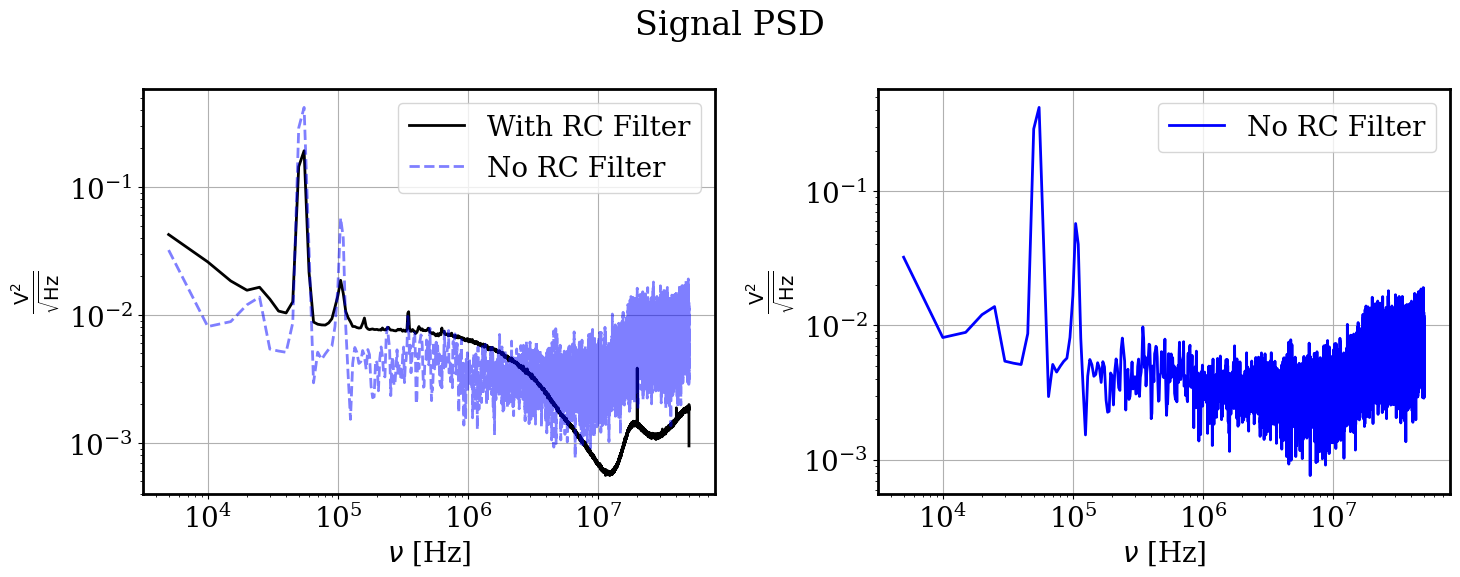

In [63]:
fig, ax = plt.subplots(1,2,figsize=(15,6))
ax[0].loglog(-1*freq_sig[npt_sig//2:][::-1],PSD_noise[npt_sig//2:][::-1],c='k',label='With RC Filter', linewidth=2)
ax[0].loglog(-1*freq_sig_NORC[npt_sig//2:][::-1],PSD_noise_NORC[npt_sig//2:][::-1],c='b',label='No RC Filter', linewidth=2, linestyle='--',alpha=0.5)
ax[1].loglog(-1*freq_sig_NORC[npt_sig//2:][::-1],PSD_noise_NORC[npt_sig//2:][::-1],c='b',label='No RC Filter', linewidth=2)
ax[0].set_xlabel(r"$\nu$ [Hz]")
ax[0].set_ylabel(r"$\frac{\text{V}^{2}}{\sqrt{\text{Hz}}}$")
ax[1].set_xlabel(r"$\nu$ [Hz]")
ax[1].set_ylabel(r"$\frac{\text{V}^{2}}{\sqrt{\text{Hz}}}$")
ax[0].legend()
ax[0].grid()
ax[1].legend()
ax[1].grid()
fig.suptitle('Signal PSD')
fig.tight_layout()

In [31]:
# Calcolo il segnale atteso (medio), l'ultimo ingrediente per il filtro ottimo

medium = Medium(NPS = PSD_noise)
medium.create_medium(signal_matrix,np.zeros(signal_matrix.shape[0]))
medium_pulse = medium.get_medium()

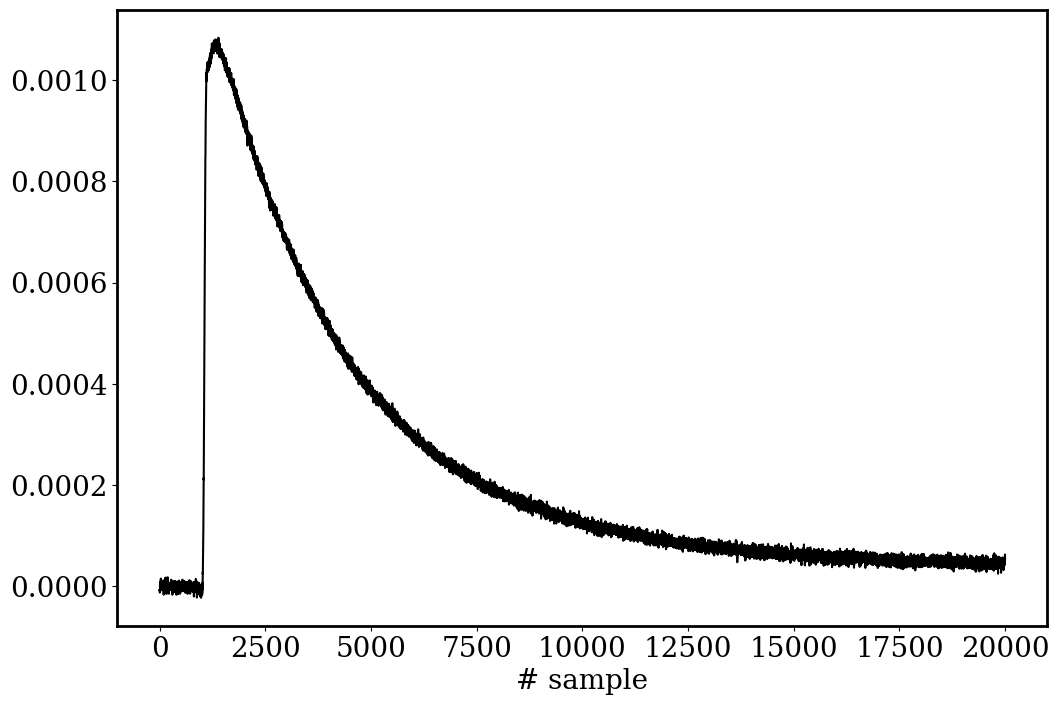

In [32]:
plt.plot(medium_pulse,c='k')
plt.xlabel("# sample")
plt.show()

In [33]:
# Creo il filtro H e lo applico ai dati su cui ho calcolato il medio
H = create_filter(medium_pulse,PSD_noise)

signal_matrix_filtered_f =  np.fft.fft(signal_matrix, axis=1)*H # dati filtrati dominio freq
signal_matrix_filtered_t =  np.fft.ifft(signal_matrix_filtered_f).real   #dati filtrati dominio temp
signal_matrix_filtered_t =  np.concatenate((signal_matrix_filtered_t[:,int(signal_matrix_filtered_t.shape[1]/2):signal_matrix_filtered_t.shape[1]], signal_matrix_filtered_t[:,0:int(signal_matrix_filtered_t.shape[1]/2)]),axis=1)

noise_matrix_filtered_f =  np.fft.fft(noise_matrix, axis=1)*H # dati filtrati dominio freq
noise_matrix_filtered_t =  np.fft.ifft(noise_matrix_filtered_f).real   #dati filtrati dominio temp
noise_matrix_filtered_t =  np.concatenate((noise_matrix_filtered_t[:,int(noise_matrix_filtered_t.shape[1]/2):noise_matrix_filtered_t.shape[1]], noise_matrix_filtered_t[:,0:int(signal_matrix_filtered_t.shape[1]/2)]),axis=1)

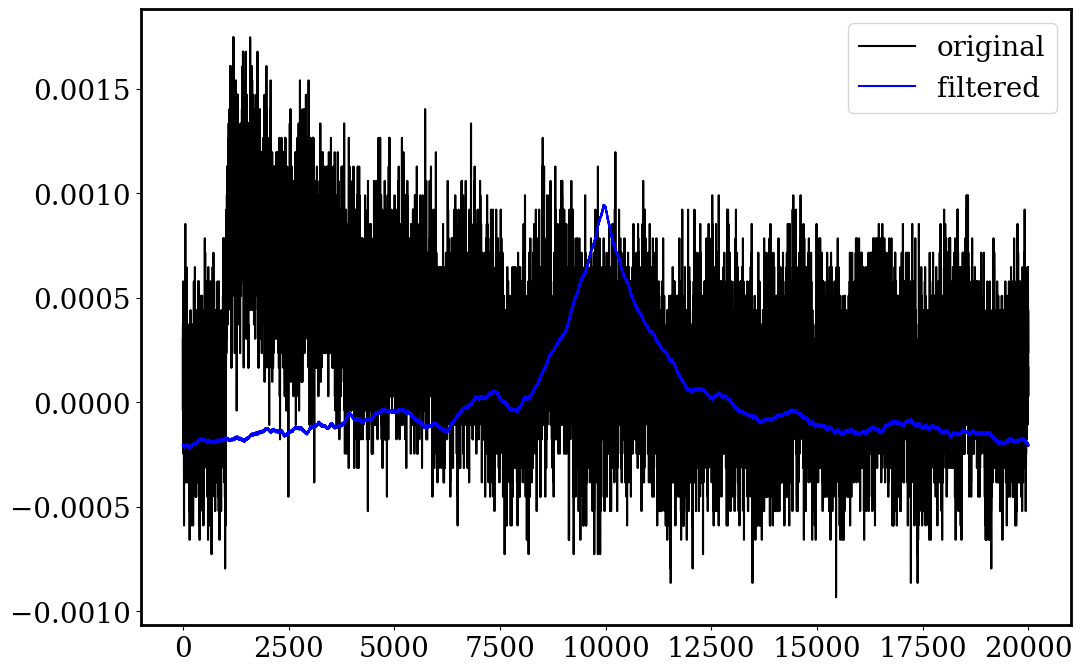

In [34]:
#Guardo come cambiano i dati prima e dopo il filtro ottimo
nev = 10
#===================
plt.plot(signal_matrix[nev],c='k',label="original")
plt.plot(signal_matrix_filtered_t[nev],label="filtered",c='b')
plt.legend()
plt.show()

In [35]:
H.shape

(20000,)

In [36]:
with open('Filter.txt','w') as f:
    for h in H:
        f.writelines(str(h.real)+'\t'+str(h.imag)+'\n')

# Applico il filtro ottimo per valutare l'ampiezza dei dati

In [37]:
OFT, OFF, OFdelay, OFtest = applyOF(signal_matrix,H)

# OFT è l'ampiezza del segnale, calcolata con il filtro ottimo nel dominio del tempo
# OFF è l'ampiezza del segnale, calcolata con il filtro ottimo nel dominio delle frequenze, dovrebbe essere uguale
#     (o molto simile) a OFT
# OFdelay e OFtest ignoratele.

In [38]:
with open('OFF_Tension.txt','w') as f:
    for o in OFF:
        f.writelines(str(o)+'\n')

with open('OFT_Tension.txt','w') as f:
    for o in OFT:
        f.writelines(str(o)+'\n')

In [39]:
OFT_noise, OFF_noise, _, _ = applyOF(noise_matrix,H) 

In [40]:
np.sqrt(abs(np.mean(medium_pulse[:700])))

0.0008855764274782089